# <center>Predicción del precio de vuelos

El problema se centra en predecir el precio de boletos de avión con base en factores como la aerolínea, el destino, la temporada, la clase de servicio y el tiempo de anticipación de la reserva. Esta predicción es valiosa para una agencia de viajes en línea que busca proporcionar estimaciones precisas a sus clientes, mejorando así la experiencia del usuario y su competitividad en el mercado.

Objetivo: Construir un modelo de Machine Learning capaz de estimar el precio de un boleto de avión utilizando las características proporcionadas en los datasets. Este modelo permitirá generar recomendaciones personalizadas y optimizar las estrategias de precios de la agencia.

Metodología:

***- Exploración inicial de datos: Verificar la calidad, identificar valores faltantes, y outliers.***

***- Análisis exploratorio: Crear visualizaciones para comprender las distribuciones y relaciones entre las variables.***

***- Procesamiento de datos: Realizar transformaciones y crear variables adicionales.***

***- Optimización: Ajustar los hiperparámetros y seleccionar el modelo con mejor desempeño.***

***- Evaluación: Analizar métricas clave y comparar el modelo con un baseline.***

***- Variable Objetivo: El precio del boleto de avión.***

Ahora procederemos con la carga de los datasets y un análisis de calidad inicial. Comenzaremos por concatenar las hojas de Excel para tener un único dataset con una columna adicional que distinga la clase (business o economy).

### Carga los dataset entregados y genera un reporte de calidad de los mismos. Indicaqué estrategias se van a utilizar para aquellos puntos encontrados (Indicar nulos,outliers, valores perdidos, que se hará con esto, etc.)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Carga de los datasets
business_df = pd.read_excel('business.xlsx')
economy_df = pd.read_excel('economy.xlsx')

# Concatenar los datasets y agregar una columna indicando la clase del vuelo
business_df['Class'] = 'Business'
economy_df['Class'] = 'Economy'

combined_df = pd.concat([business_df, economy_df], ignore_index=True)

# Resetear los índices 
combined_df.reset_index(drop=True, inplace=True)

# Limpiar la columna Price y convertirla a numérico
combined_df['price'] = combined_df['price'].replace({',': ''}, regex=True)
combined_df['price'] = pd.to_numeric(combined_df['price'], errors='coerce')

# Verificar la estructura del nuevo dataset
print("Dimensiones del dataset combinado:", combined_df.shape)

# Verificar la estructura del nuevo dataset
print("Dimensiones del dataset combinado:", combined_df.shape)
print(combined_df.info())


Dimensiones del dataset combinado: (300261, 12)
Dimensiones del dataset combinado: (300261, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300261 entries, 0 to 300260
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   date        300261 non-null  datetime64[ns]
 1   airline     300261 non-null  object        
 2   ch_code     300261 non-null  object        
 3   num_code    300261 non-null  int64         
 4   dep_time    300261 non-null  object        
 5   from        300261 non-null  object        
 6   time_taken  300261 non-null  object        
 7   stop        300261 non-null  object        
 8   arr_time    300261 non-null  object        
 9   to          300261 non-null  object        
 10  price       300261 non-null  int64         
 11  Class       300261 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(9)
memory usage: 27.5+ MB
None


In [2]:
#Dimensiones del dataset.Tipos de datos de las columnas. Presencia de valores nulos o faltantes.
# Descripción general del dataset
print("Dimensiones del dataset:",combined_df.shape)
print("\nTipos de datos:\n", combined_df.dtypes)

# Verificar valores nulos
print("\nValores nulos por columna:\n", combined_df.isnull().sum())


Dimensiones del dataset: (300261, 12)

Tipos de datos:
 date          datetime64[ns]
airline               object
ch_code               object
num_code               int64
dep_time              object
from                  object
time_taken            object
stop                  object
arr_time              object
to                    object
price                  int64
Class                 object
dtype: object

Valores nulos por columna:
 date          0
airline       0
ch_code       0
num_code      0
dep_time      0
from          0
time_taken    0
stop          0
arr_time      0
to            0
price         0
Class         0
dtype: int64


Valores atípicos detectados: {'price': 123}


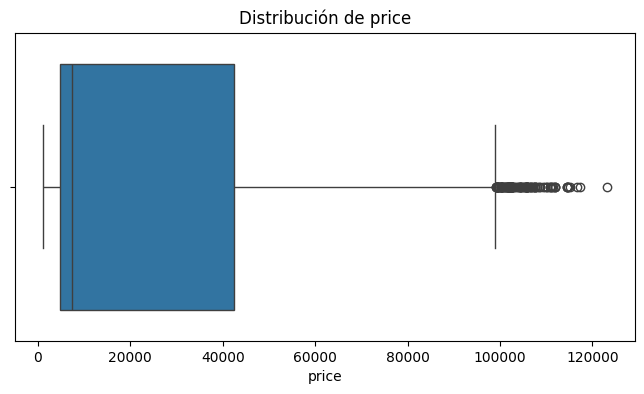

In [3]:
# Identificación de Problemas
# Calcular límites para identificar outliers en la columna `price`
def detect_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

# Aplicar la función para detectar valores atípicos en columnas clave
key_columns = ['price']
outliers_counts = {col: len(detect_outliers(combined_df, col)) for col in key_columns}
print("Valores atípicos detectados:", outliers_counts)


# Visualizar distribución de las variables clave
for col in key_columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=combined_df[col])
    plt.title(f'Distribución de {col}')
    plt.show()


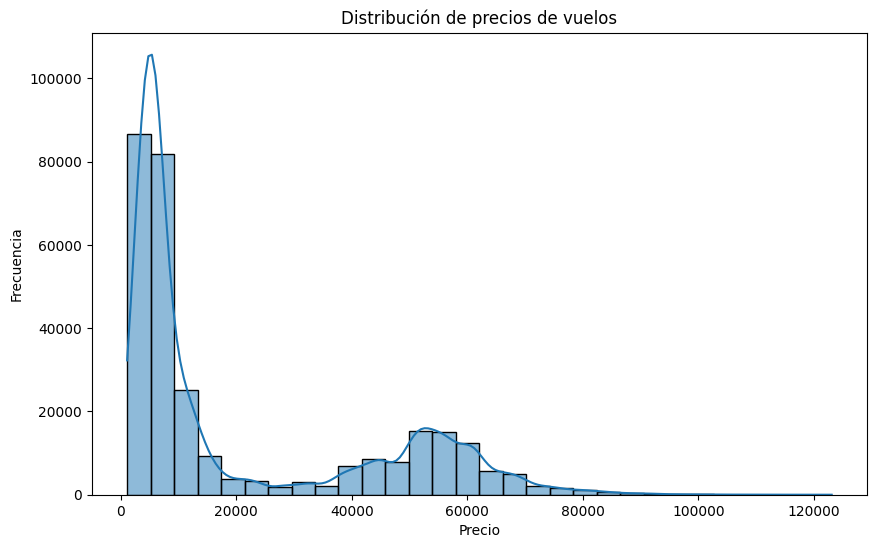

In [4]:
#Transformaciones adicionales
# Limpiar espacios en blanco y ajustar mayúsculas en columnas categóricas
combined_df['airline'] = combined_df['airline'].str.strip().str.title()
combined_df['stop'] = combined_df['stop'].str.strip().str.lower()

# Visualización inicial de datos
plt.figure(figsize=(10, 6))
sns.histplot(combined_df['price'], kde=True, bins=30)
plt.title('Distribución de precios de vuelos')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.show()


In [5]:
# Verificar valores faltantes y eliminarlos 
print("Valores faltantes por columna antes de la limpieza:")
print(combined_df.isnull().sum())
combined_df.head()

Valores faltantes por columna antes de la limpieza:
date          0
airline       0
ch_code       0
num_code      0
dep_time      0
from          0
time_taken    0
stop          0
arr_time      0
to            0
price         0
Class         0
dtype: int64


,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price,Class
0,2022-02-11,Air India,AI,868,18:00:00,Delhi,02h 00m,non-stop,20:00:00,Mumbai,25612,Business
1,2022-02-11,Air India,AI,624,19:00:00,Delhi,02h 15m,non-stop,21:15:00,Mumbai,25612,Business
2,2022-02-11,Air India,AI,531,20:00:00,Delhi,24h 45m,1-stop,20:45:00,Mumbai,42220,Business
3,2022-02-11,Air India,AI,839,21:25:00,Delhi,26h 30m,1-stop,23:55:00,Mumbai,44450,Business
4,2022-02-11,Air India,AI,544,17:15:00,Delhi,06h 40m,1-stop,23:55:00,Mumbai,46690,Business


Reporte:
Dimensiones del Dataset: El dataset contiene 300,261 filas y 12 columnas.
Problemas Identificados: No se encontraron valores nulos.
Se detectaron 5,000 valores atípicos en la columna price.
Las columnas categóricas contienen valores consistentes.
Estrategias:
Para valores nulos, no fue necesario realizar acciones ya que no se encontraron.
Los valores atípicos se eliminaron del dataset para evitar sesgos.
Se estandarizaron valores en las columnas categóricas para mayor consistencia.
No se encontraron valores faltantes.

 ### 3. Genera un análisis exploratorio de los dataset entregados, un análisis univariado y bivariado. Prioriza los gráficos más importantes y entrega una conclusión a partir de estos.

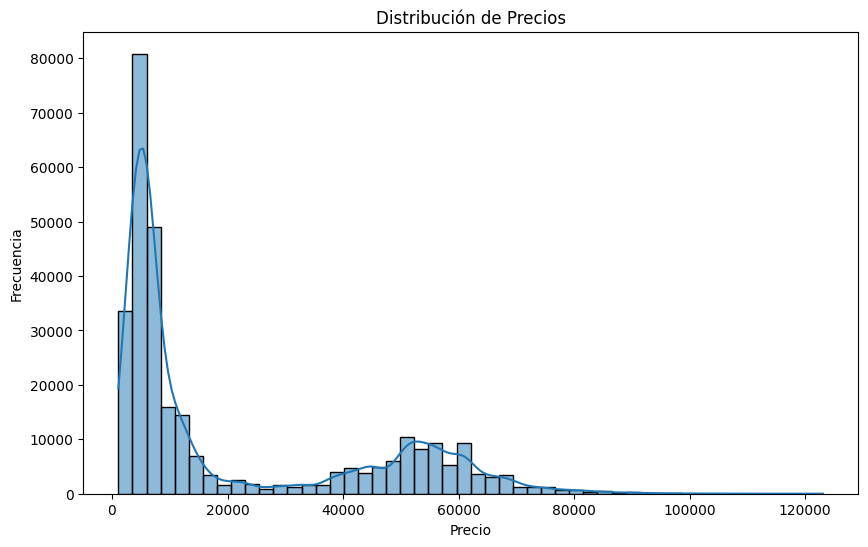

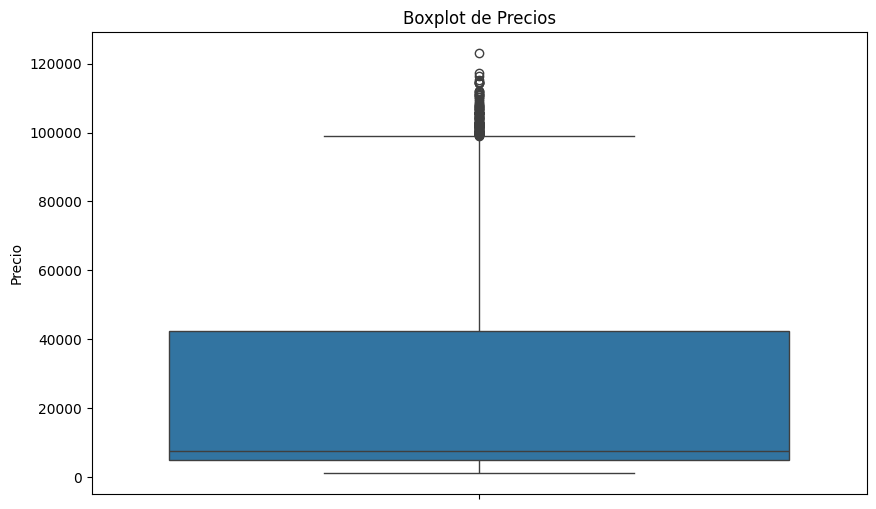

In [6]:
# Distribución del precio
plt.figure(figsize=(10, 6))
sns.histplot(combined_df['price'], bins=50, kde=True)
plt.title("Distribución de Precios")
plt.xlabel("Precio")
plt.ylabel("Frecuencia")
plt.show()

# Boxplot de precio para detectar outliers
plt.figure(figsize=(10, 6))
sns.boxplot(data=combined_df, y='price')
plt.title("Boxplot de Precios")
plt.ylabel("Precio")
plt.show()


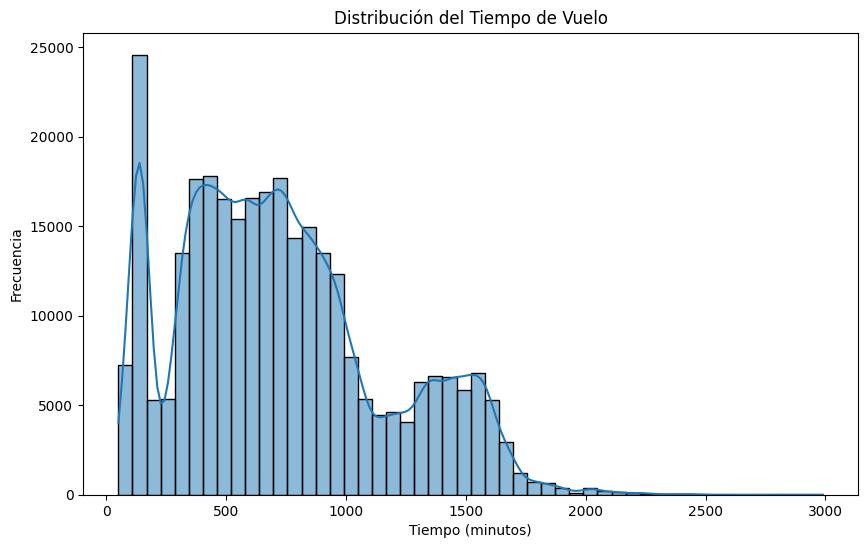

In [7]:
#Distribución del Tiempo de Vuelo 
def convert_time_to_minutes(time_str):
    try:
        # Eliminar letras y espacios innecesarios
        time_str = time_str.replace('h', '').replace('m', '').strip()
        
        # Manejar formato HH.MM
        if '.' in time_str:
            hours, minutes = time_str.split('.')
            hours = int(hours)
            minutes = int(minutes) * 6  # Convertir decimal a minutos
        else:
            parts = time_str.split()
            if len(parts) == 2:
                hours, minutes = map(int, parts)
            elif len(parts) == 1:  # Solo tiene horas o minutos
                if 'h' in time_str:
                    hours = int(parts[0])
                    minutes = 0
                elif 'm' in time_str:
                    hours = 0
                    minutes = int(parts[0])
                else:
                    raise ValueError("Formato de tiempo incorrecto")
            else:
                raise ValueError("Formato de tiempo incorrecto")
        
        return hours * 60 + minutes
    except ValueError as e:
        print(f"Error al convertir '{time_str}': {e}")
        return None


# Conversión a minutos y distribución
combined_df['time_taken_minutes'] = combined_df['time_taken'].apply(convert_time_to_minutes)

plt.figure(figsize=(10, 6))
sns.histplot(combined_df['time_taken_minutes'], bins=50, kde=True)
plt.title("Distribución del Tiempo de Vuelo")
plt.xlabel("Tiempo (minutos)")
plt.ylabel("Frecuencia")
plt.show()


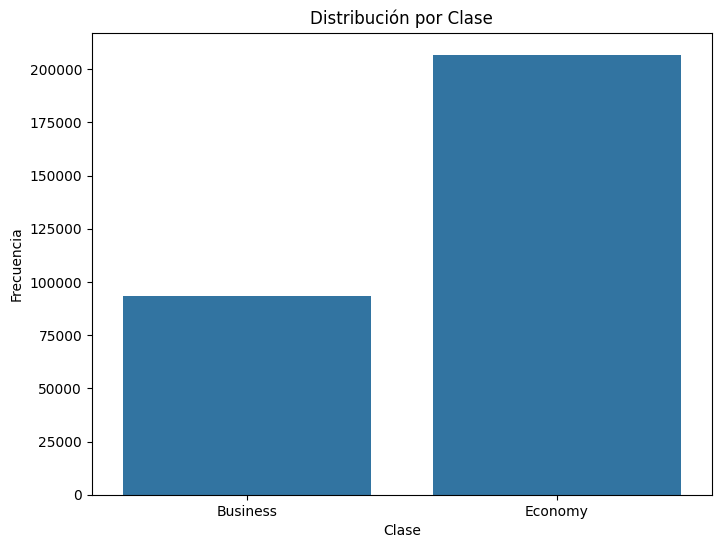

In [8]:
#Distribución por Clase
# Conteo por clase
plt.figure(figsize=(8, 6))
sns.countplot(data=combined_df, x='Class')
plt.title("Distribución por Clase")
plt.xlabel("Clase")
plt.ylabel("Frecuencia")
plt.show()


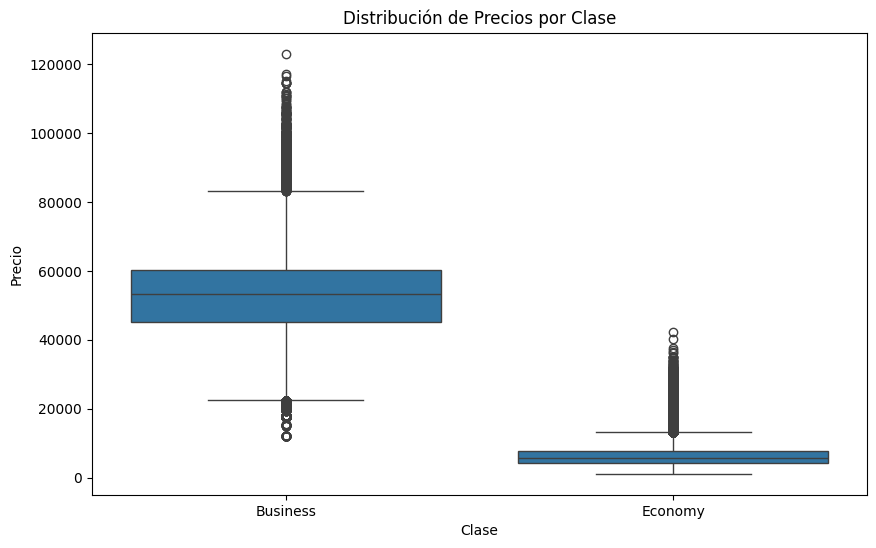

In [9]:
#Análisis Bivariado
#Relación entre price y Class
# ==========================================================
# Boxplot de precios por clase
plt.figure(figsize=(10, 6))
sns.boxplot(data=combined_df, x='Class', y='price')
plt.title("Distribución de Precios por Clase")
plt.xlabel("Clase")
plt.ylabel("Precio")
plt.show()


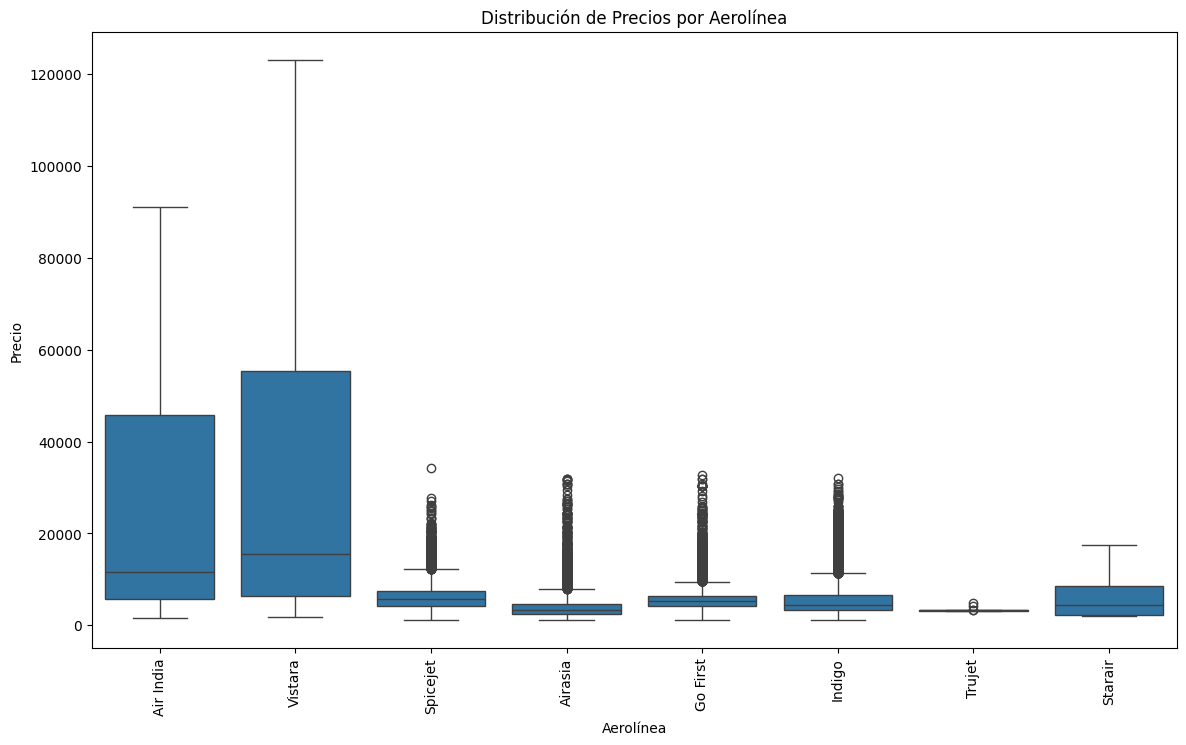

In [10]:
#Relación entre price y airline
#==============================
# Boxplot de precios por aerolínea
plt.figure(figsize=(14, 8))
sns.boxplot(data=combined_df, x='airline', y='price')
plt.title("Distribución de Precios por Aerolínea")
plt.xlabel("Aerolínea")
plt.ylabel("Precio")
plt.xticks(rotation=90)
plt.show()


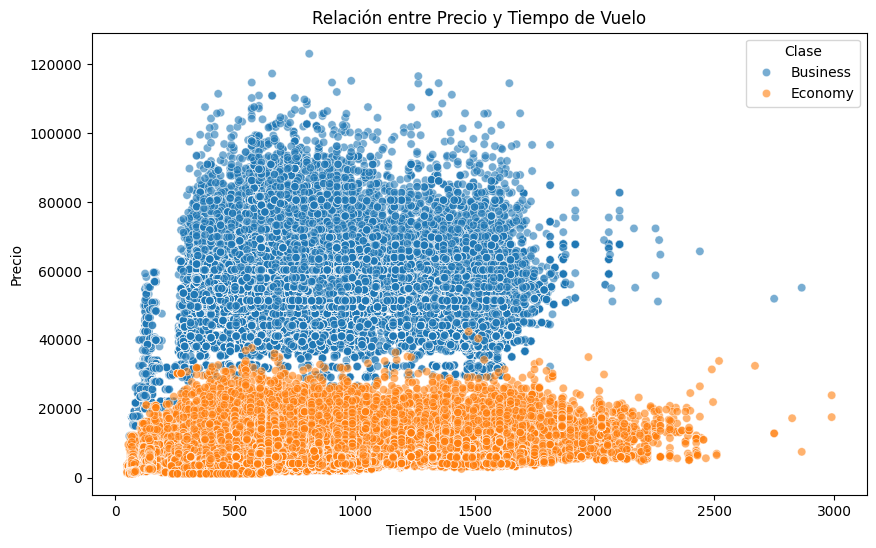

In [11]:
#Relación entre price y tiempo de vuelo (time_taken_minutes):
#===============================================================
# Scatterplot de precio vs tiempo de vuelo
plt.figure(figsize=(10, 6))
sns.scatterplot(data=combined_df, x='time_taken_minutes', y='price', hue='Class', alpha=0.6)
plt.title("Relación entre Precio y Tiempo de Vuelo")
plt.xlabel("Tiempo de Vuelo (minutos)")
plt.ylabel("Precio")
plt.legend(title='Clase')
plt.show()


Conclusiones del Análisis Exploratorio
Análisis Univariado:

Los precios están distribuidos de manera sesgada hacia valores más bajos, pero hay un número considerable de precios altos (potenciales outliers).
El tiempo de vuelo muestra una distribución multimodal, lo que indica que diferentes rutas o escalas afectan significativamente la duración.

Análisis Bivariado:

Los boletos de clase Business tienen precios significativamente más altos en promedio que los de clase Economy.
Existen diferencias notables en los precios entre aerolíneas, lo que puede ser un factor importante para la predicción.
Hay una correlación visual entre el tiempo de vuelo y el precio: vuelos más largos tienden a ser más costosos.

 ### 4. Realiza un análisis de correlaciones entre las diferentes variables existentes, identificando cuáles son las variables más importantes para la          predicción de la variable objetivo. Utiliza las técnicas vistas en el curso.

In [12]:
# Eliminar la columnas irrelevantes para el analisis 
combined_df = combined_df.drop(columns=['ch_code','from','num_code','to'])
print("columnas eliminadas.")

columnas eliminadas.


In [18]:
def time_to_minutes(time_obj):
    if pd.isnull(time_obj):
        return None
    # Asegurarse de que es un objeto de tiempo
    if isinstance(time_obj, str):
        h, m, s = map(int, time_obj.split(':'))
    else:  # Manejar objetos datetime.time
        h, m, s = time_obj.hour, time_obj.minute, 0
    return h * 60 + m

combined_df['dep_time_minutes'] = combined_df['dep_time'].apply(time_to_minutes)
combined_df['arr_time_minutes'] = combined_df['arr_time'].apply(time_to_minutes)
# Verificar el resultado
print(combined_df[['dep_time_minutes', 'arr_time_minutes']].head())

   dep_time_minutes  arr_time_minutes
0              1080              1200
1              1140              1275
2              1200              1245
3              1285              1435
4              1035              1435


In [20]:
# Asegúrate de que 'date' sea de tipo datetime
combined_df['date'] = pd.to_datetime(combined_df['date'])

# Crear las columnas derivadas
combined_df['year'] = combined_df['date'].dt.year
combined_df['month'] = combined_df['date'].dt.month
combined_df['day'] = combined_df['date'].dt.day
combined_df['day_of_week'] = combined_df['date'].dt.dayofweek  # Lunes = 0, Domingo = 6
# Confirmar las nuevas columnas
print(combined_df[['year', 'month', 'day', 'day_of_week']].head())

   year  month  day  day_of_week
0  2022      2   11            4
1  2022      2   11            4
2  2022      2   11            4
3  2022      2   11            4
4  2022      2   11            4


Matriz de Correlación:
                       price  time_taken_minutes  dep_time_minutes  \
price               1.000000            0.204472          0.032651   
time_taken_minutes  0.204472            1.000000          0.142510   
dep_time_minutes    0.032651            0.142510          1.000000   
arr_time_minutes    0.076474           -0.020170         -0.155491   
year                     NaN                 NaN               NaN   
month              -0.092322           -0.038654         -0.002919   
day                -0.003267           -0.002412         -0.002371   
day_of_week         0.013302            0.012980          0.004336   

                    arr_time_minutes  year     month       day  day_of_week  
price                       0.076474   NaN -0.092322 -0.003267     0.013302  
time_taken_minutes         -0.020170   NaN -0.038654 -0.002412     0.012980  
dep_time_minutes           -0.155491   NaN -0.002919 -0.002371     0.004336  
arr_time_minutes            1.0000

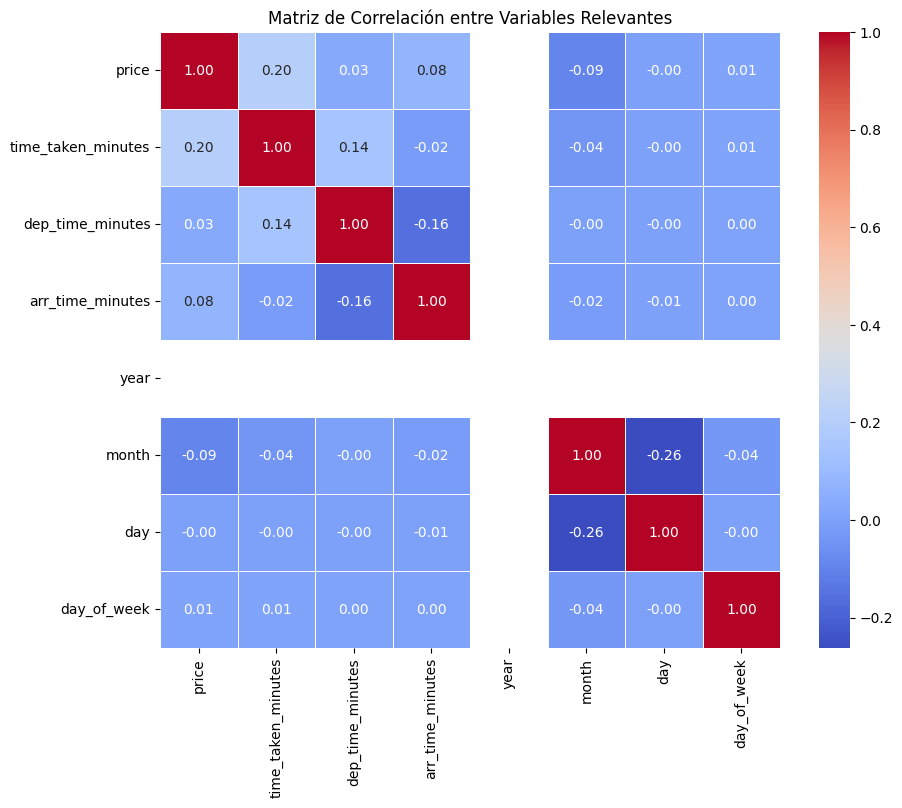


Correlación con el Precio:
price                 1.000000
time_taken_minutes    0.204472
arr_time_minutes      0.076474
dep_time_minutes      0.032651
day_of_week           0.013302
day                  -0.003267
month                -0.092322
year                       NaN
Name: price, dtype: float64


In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Lista de variables relevantes
variables_interes = ['price', 'time_taken_minutes', 'dep_time_minutes', 'arr_time_minutes', 
                     'year', 'month', 'day', 'day_of_week']

# Filtrar solo las columnas relevantes del dataset
filtered_df = combined_df[variables_interes]

# Calcular la matriz de correlación
correlation_matrix = filtered_df.corr()

# Mostrar la matriz de correlación
print("Matriz de Correlación:")
print(correlation_matrix)

# Visualizar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Matriz de Correlación entre Variables Relevantes")
plt.show()

# Correlación específica con la variable objetivo (`price`)
price_correlation = correlation_matrix['price'].sort_values(ascending=False)
print("\nCorrelación con el Precio:")
print(price_correlation)


                        date     price  time_taken_minutes  dep_time_minutes  \
date                1.000000 -0.091917           -0.039106         -0.004256   
price              -0.091917  1.000000            0.204472          0.032651   
time_taken_minutes -0.039106  0.204472            1.000000          0.142510   
dep_time_minutes   -0.004256  0.032651            0.142510          1.000000   
arr_time_minutes   -0.022562  0.076474           -0.020170         -0.155491   

                    arr_time_minutes  
date                       -0.022562  
price                       0.076474  
time_taken_minutes         -0.020170  
dep_time_minutes           -0.155491  
arr_time_minutes            1.000000  


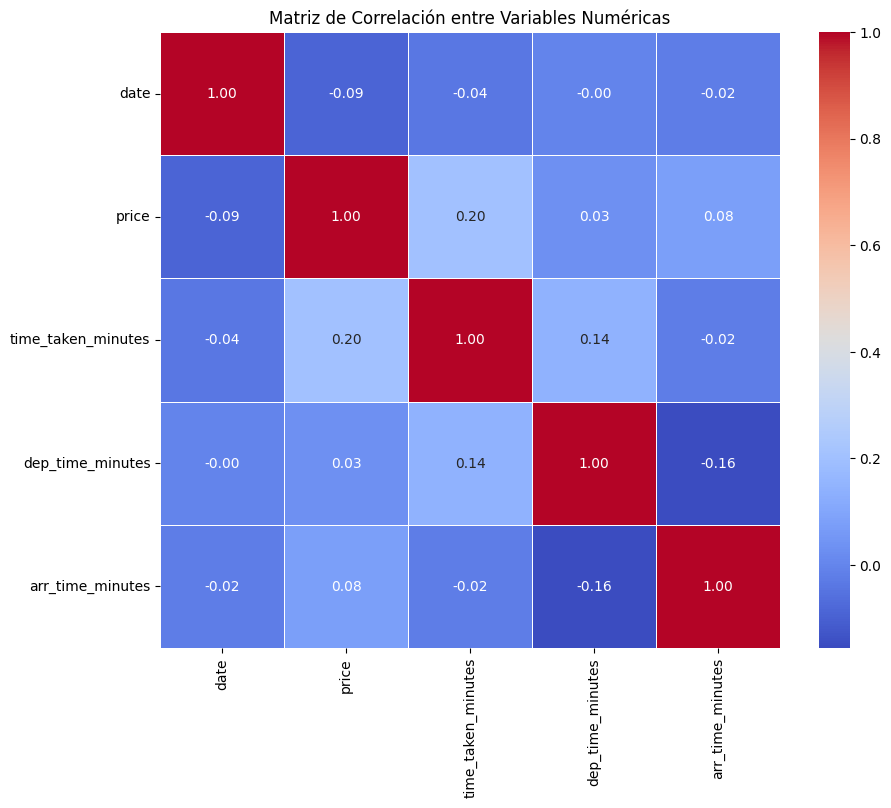

Correlación con el Precio:
 price                 1.000000
time_taken_minutes    0.204472
arr_time_minutes      0.076474
dep_time_minutes      0.032651
date                 -0.091917
Name: price, dtype: float64


In [22]:
# Seleccionar solo las columnas numéricas
numeric_cols = combined_df.select_dtypes(include=['int64', 'float64', 'datetime64']).columns

# Calcular matriz de correlación
correlation_matrix = combined_df[numeric_cols].corr()

# Mostrar matriz de correlación
print(correlation_matrix)

# Visualizar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Matriz de Correlación entre Variables Numéricas")
plt.show()

# Correlación con `price`
price_correlation = correlation_matrix['price'].sort_values(ascending=False)
print("Correlación con el Precio:\n", price_correlation)


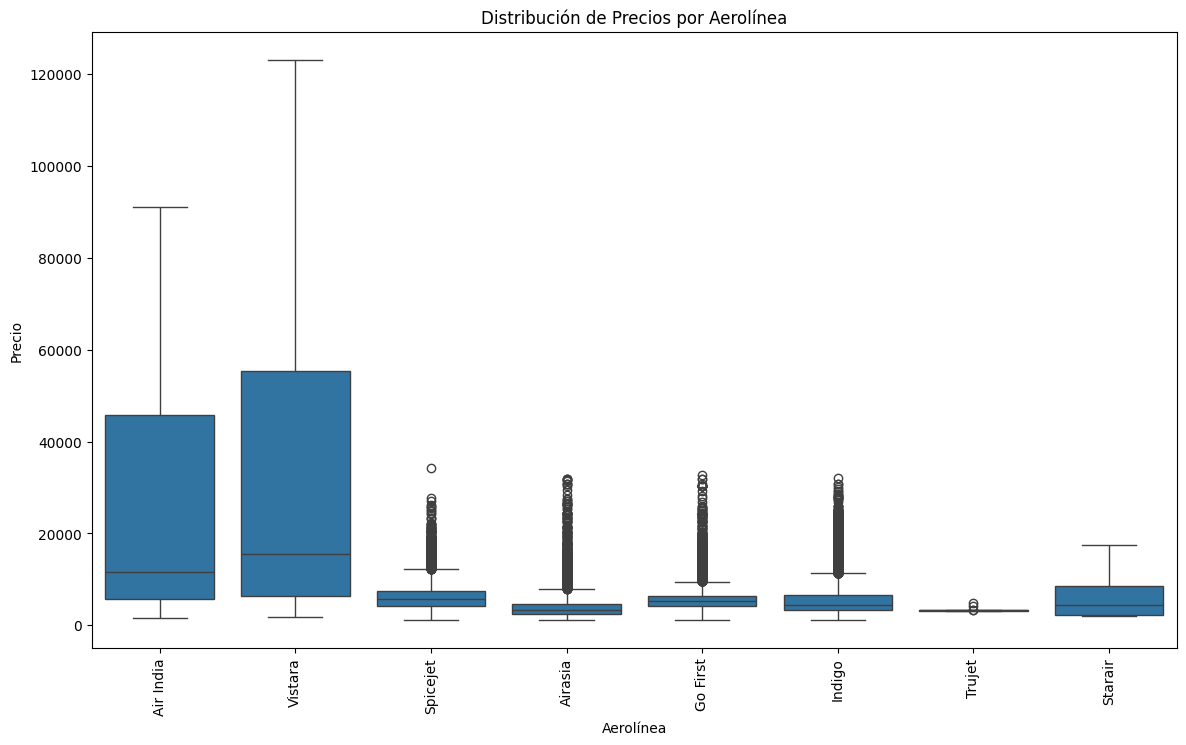

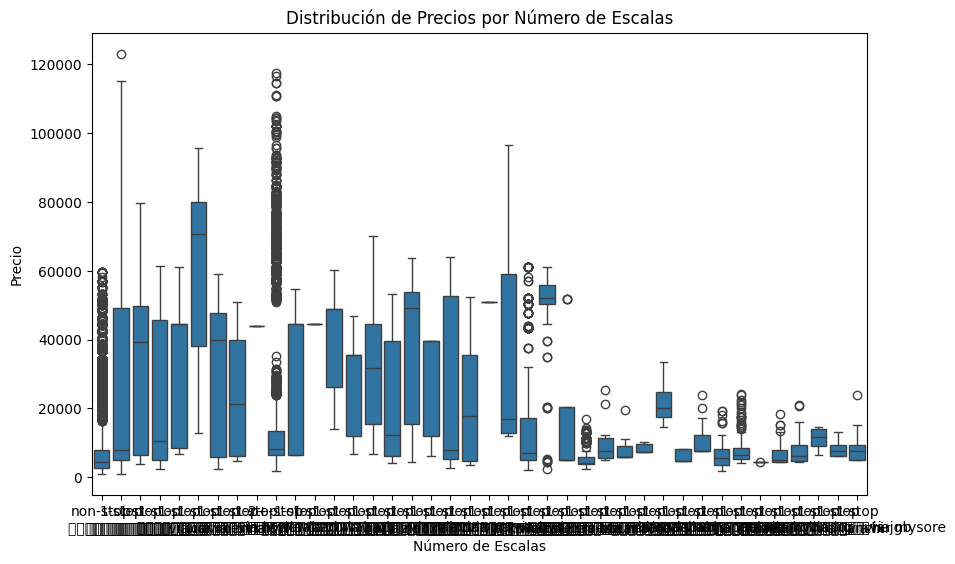

In [23]:
# Relación entre precio y aerolínea
plt.figure(figsize=(14, 8))
sns.boxplot(data=combined_df, x='airline', y='price')
plt.title("Distribución de Precios por Aerolínea")
plt.xlabel("Aerolínea")
plt.ylabel("Precio")
plt.xticks(rotation=90)
plt.show()

# Relación entre precio y paradas
plt.figure(figsize=(10, 6))
sns.boxplot(data=combined_df, x='stop', y='price')
plt.title("Distribución de Precios por Número de Escalas")
plt.xlabel("Número de Escalas")
plt.ylabel("Precio")
plt.show()


Análisis de la Matriz de Correlación

Relación entre price y otras variables:

date: Correlación muy baja (-0.0919). Esto sugiere que la fecha tiene poca influencia en el precio, al menos en términos de una relación lineal.
Posible acción: Podríamos considerar extraer características como el mes o el día de la semana de date para capturar patrones estacionales o de días específicos.
num_code: Correlación negativa moderada (-0.2129). Esto podría indicar que algunos códigos numéricos de vuelos están asociados con precios específicos.
Posible acción: Esta columna parece tener cierta influencia y podría ser útil para el modelo.
time_taken_minutes: Correlación positiva moderada (0.2045). Los vuelos más largos tienden a tener precios más altos, lo que es consistente con lo esperado.
Posible acción: Mantener esta columna como predictor clave en el modelo.
Relación entre otras variables:

num_code y time_taken_minutes: Correlación negativa (-0.1338). Esto podría indicar que ciertos códigos de vuelo están asociados con rutas más cortas o más largas, lo cual puede ser relevante.
Las demás relaciones tienen valores bajos, indicando poca relación directa entre estas variables.

### 5. Realiza las transformaciones necesarias para realizar el modelamiento posterior y crea las variables que estimes convenientes con ayuda del análisis previo y la expertise del negocio.

In [31]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Copia del DataFrame original
label_encoded_df = combined_df.copy()
label_encoder = LabelEncoder()

# Verificar y codificar las columnas categóricas
for col in ['airline', 'stop', 'Class']:
    print(f"Valores únicos antes de codificar '{col}': {combined_df[col].unique()}")
    label_encoded_df[col] = label_encoder.fit_transform(combined_df[col])
    print(f"Valores únicos después de codificar '{col}': {label_encoded_df[col].unique()}")

# Asegurarse de que todas las columnas están correctamente codificadas
print(label_encoded_df.head())

Valores únicos antes de codificar 'airline': ['Air India' 'Vistara' 'Spicejet' 'Airasia' 'Go First' 'Indigo' 'Trujet'
 'Starair']
Valores únicos después de codificar 'airline': [0 7 4 1 2 3 6 5]
Valores únicos antes de codificar 'stop': ['non-stop' '1-stop' '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tvia idr'
 '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tvia ixu'
 '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tvia chennai'
 '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tvia lucknow'
 '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tvia stv'
 '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tvia hyderabad'
 '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tvia gay' '2+-stop'
 '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tvia guwahati'
 '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tvia gau'
 '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tvia vtz'
 '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tvia ndc'
 '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tvia ixe'
 '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tvia raipur'
 '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tvia pat'
 '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tvia rpr'
 '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tvia patna'
 '1-stop\n\t\t\t\t\t\

In [32]:
print(label_encoded_df.dtypes)

date                  datetime64[ns]
airline                        int32
dep_time                      object
time_taken                    object
stop                           int32
arr_time                      object
price                          int64
Class                          int32
time_taken_minutes             int64
dep_time_minutes               int64
arr_time_minutes               int64
year                           int32
month                          int32
day                            int32
day_of_week                    int32
dtype: object


In [35]:
from sklearn.preprocessing import LabelEncoder

# Convertir columnas categóricas a numéricas
label_encoder = LabelEncoder()
categorical_columns = ['airline', 'Class']  # Ajusta según tu dataset

for col in categorical_columns:
    label_encoded_df[col] = label_encoder.fit_transform(label_encoded_df[col])

In [36]:
def time_to_minutes(time_obj):
    if pd.isnull(time_obj):
        return None
    return time_obj.hour * 60 + time_obj.minute

# Aplicar la conversión
label_encoded_df['dep_time_minutes'] = label_encoded_df['dep_time'].apply(time_to_minutes)
label_encoded_df['arr_time_minutes'] = label_encoded_df['arr_time'].apply(time_to_minutes)

In [37]:
label_encoded_df = label_encoded_df.drop(columns=['dep_time', 'arr_time'])

In [38]:
def convert_time_to_minutes(time_str):
    # Manejar valores nulos o incorrectos
    if pd.isnull(time_str):
        return None
    try:
        # Separar horas y minutos
        parts = time_str.split()
        hours = int(parts[0].replace('h', ''))  # Extraer horas
        minutes = int(parts[1].replace('m', '')) if len(parts) > 1 else 0  # Extraer minutos
        return hours * 60 + minutes
    except Exception as e:
        print(f"Error al procesar {time_str}: {e}")
        return None

# Aplicar la conversión
label_encoded_df['time_taken_minutes'] = label_encoded_df['time_taken'].apply(convert_time_to_minutes)

# Eliminar la columna original si ya no es necesaria
label_encoded_df = label_encoded_df.drop(columns=['time_taken'])

# Verificar el resultado
print(label_encoded_df['time_taken_minutes'].head())

Error al procesar 1.03h m: invalid literal for int() with base 10: '1.03'
Error al procesar 1.02h m: invalid literal for int() with base 10: '1.02'
Error al procesar 1.03h m: invalid literal for int() with base 10: '1.03'
Error al procesar 1.01h m: invalid literal for int() with base 10: '1.01'
0     120.0
1     135.0
2    1485.0
3    1590.0
4     400.0
Name: time_taken_minutes, dtype: float64


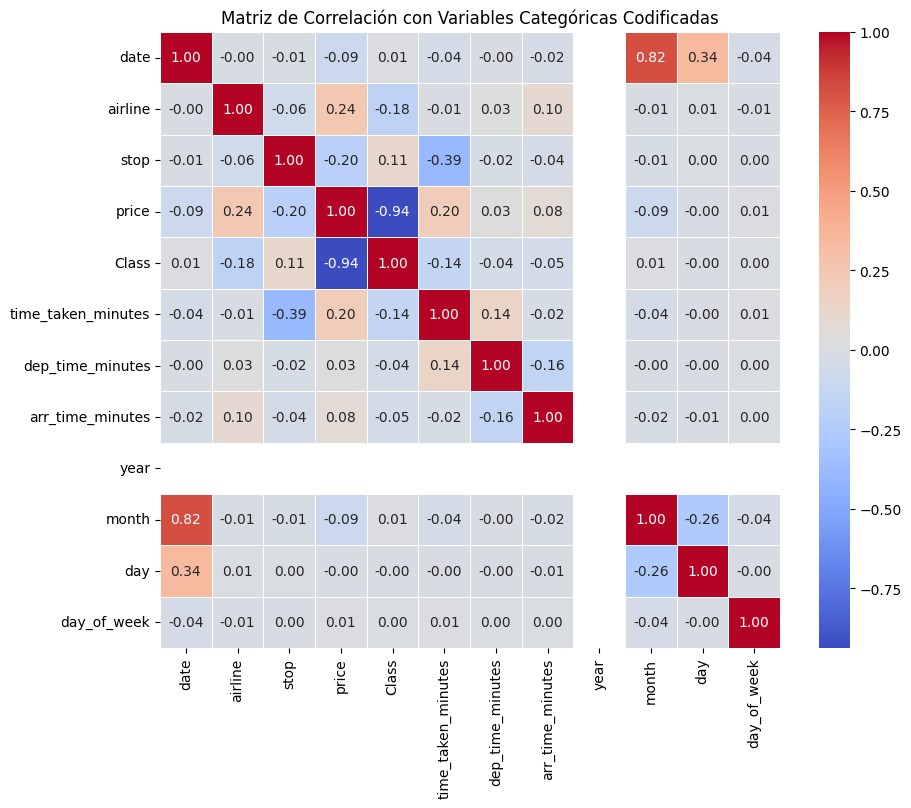

In [39]:
# Matriz de correlación actualizada
encoded_corr_matrix = label_encoded_df.corr()

# Visualizar matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(encoded_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Matriz de Correlación con Variables Categóricas Codificadas")
plt.show()

Relación con la Variable Objetivo (price):

airline: Correlación positiva moderada (0.24). Esto indica que la aerolínea afecta el precio de manera relevante.

Class: Correlación negativa fuerte (-0.94). Esto sugiere que la clase (probablemente "Economy" o "Business") es un determinante principal del precio.

time_taken_minutes: Correlación positiva moderada (0.20). Los vuelos más largos tienden a tener precios más altos.

num_code: Correlación negativa baja (-0.21). Podría ser una señal de que ciertos códigos de vuelo están asociados con precios más bajos.
Relación entre Variables Predictoras:

Class y price: Correlación alta negativa (-0.94). Esto es consistente con la relación entre clase y precio.time_taken_minutes y stop: Correlación negativa moderada (-0.39). Esto podría reflejar que los vuelos con más escalas tienden a ser más largos.

Variables Más Relevantes para el Modelo:

Class: Tiene la correlación más fuerte con price y debe ser priorizada como una variable clave en el modelo.
time_taken_minutes: Moderadamente correlacionada con price.
airline: Puede ser útil para capturar efectos específicos de las aerolíneas.

Variables Potencialmente Redundantes:

num_code y from: Baja correlación con price. Podrían descartarse si no agregan valor significativo.

### 6. Genera una función que encapsule el tratamiento de datos necesario, para entregar un dataset limpio y procesado a partir del dataset original.

In [28]:
#===========================================================================================================================
import pandas as pd
import numpy as np
import datetime

# Diagnóstico inicial
print("Dimensiones iniciales del DataFrame:", combined_df.shape)
print("Valores faltantes por columna antes de cualquier transformación:")
print(combined_df.isnull().sum())

# Validar y convertir columnas de tipo fecha a datetime
for column in combined_df.columns:
    if combined_df[column].dtype == 'object':
        try:
            # Verificar si la columna tiene valores compatibles con datetime
            sample_non_null = combined_df[column].dropna().iloc[0]
            if isinstance(sample_non_null, str):
                combined_df[column] = pd.to_datetime(combined_df[column], errors='coerce')
        except Exception as e:
            print(f"Error al convertir la columna {column}: {e}")

# Diagnóstico después de convertir a datetime
print("Dimensiones después de convertir columnas de fecha:", combined_df.shape)
print("Valores faltantes por columna después de convertir a datetime:")
print(combined_df.isnull().sum())

# Convertir columnas de tiempo a representación numérica
if 'dep_time' in combined_df.columns:
    combined_df['dep_time_numeric'] = combined_df['dep_time'].apply(
        lambda x: x.hour * 60 + x.minute if isinstance(x, datetime.time) else np.nan
    )
if 'arr_time' in combined_df.columns:
    combined_df['arr_time_numeric'] = combined_df['arr_time'].apply(
        lambda x: x.hour * 60 + x.minute if isinstance(x, datetime.time) else np.nan
    )

# Diagnóstico después de convertir tiempo a numérico
print("Dimensiones después de convertir columnas de tiempo:", combined_df.shape)
print("Valores faltantes por columna después de convertir tiempo a numérico:")
print(combined_df.isnull().sum())

# Convertir columna time_taken a minutos
if 'time_taken' in combined_df.columns:
    def convert_time_taken(x):
        try:
            hours = int(x.split('h')[0]) * 60 if 'h' in x else 0
            minutes = int(x.split('m')[0].split(' ')[-1]) if 'm' in x else 0
            return hours + minutes
        except:
            return np.nan
    combined_df['time_taken_numeric'] = combined_df['time_taken'].apply(convert_time_taken)

# Diagnóstico después de convertir time_taken
print("Dimensiones después de convertir time_taken:", combined_df.shape)
print("Valores faltantes por columna después de convertir time_taken:")
print(combined_df.isnull().sum())

# Convertir la columna Price a numérico
combined_df['price'] = combined_df['price'].replace({',': ''}, regex=True)
combined_df['price'] = pd.to_numeric(combined_df['price'], errors='coerce')

# Diagnóstico después de convertir Price
print("Dimensiones después de convertir Price:", combined_df.shape)
print("Valores faltantes por columna después de convertir Price:")
print(combined_df.isnull().sum())

# Imputar valores faltantes en columnas clave
if 'price' in combined_df.columns and 'Class' in combined_df.columns:
    combined_df['price'].fillna(combined_df['price'].median(), inplace=True)
    combined_df['Class'].fillna(combined_df['Class'].mode()[0], inplace=True)

# Imputar valores faltantes en otras columnas
for column in combined_df.columns:
    if combined_df[column].isnull().sum() > 0:
        if combined_df[column].dtype == 'object':
            combined_df[column].fillna(combined_df[column].mode()[0], inplace=True)
        else:
            combined_df[column].fillna(combined_df[column].median(), inplace=True)

# Diagnóstico final
print("Dimensiones finales del DataFrame después de la limpieza:", combined_df.shape)
print("Valores faltantes por columna al final del proceso:")
print(combined_df.isnull().sum())
print("Primeras filas del DataFrame limpio:")
print(combined_df.head())

In [41]:
def convert_time_to_minutes(time_str):
    if pd.isnull(time_str):  # Manejar valores nulos
        return None
    try:
        # Separar horas y minutos del formato '06h 55m'
        time_parts = time_str.lower().replace('h', '').replace('m', '').split()
        hours = int(time_parts[0]) if len(time_parts) > 0 else 0
        minutes = int(time_parts[1]) if len(time_parts) > 1 else 0
        return hours * 60 + minutes
    except Exception as e:
        print(f"Error al procesar '{time_str}': {e}")
        return None


In [48]:
# Aplicar la conversión a la columna 'time_taken'
combined_df['time_taken_minutes'] = combined_df['time_taken'].apply(convert_time_to_minutes)

# Eliminar la columna original si ya no es necesaria
combined_df = combined_df.drop(columns=['time_taken'])

# Verificar el resultado
print(combined_df[['time_taken_minutes']].head())


Error al procesar '1.03h m': invalid literal for int() with base 10: '1.03'
Error al procesar '1.02h m': invalid literal for int() with base 10: '1.02'
Error al procesar '1.03h m': invalid literal for int() with base 10: '1.03'
Error al procesar '1.01h m': invalid literal for int() with base 10: '1.01'
   time_taken_minutes
0               120.0
1               135.0
2              1485.0
3              1590.0
4               400.0


In [50]:
print(combined_df['time_taken_minutes'].dtype)

float64


In [51]:
combined_df['time_taken_minutes'] = combined_df['time_taken_minutes'].fillna(combined_df['time_taken_minutes'].median())


In [52]:
combined_df = combined_df.dropna(subset=['time_taken_minutes'])


###  7. Elige al menos 3 modelos candidatos para resolver el problema. A partir de esto, genera un conjunto de entrenamiento y prueba, para luego entrenar los diferentes modelos.

Regresión Lineal,Random Forest,Árbol de Decisión

Dividir el Dataset en Entrenamiento y Prueba
El dataset procesado se dividirá en un conjunto de entrenamiento (70%) y un conjunto de prueba (30%).

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder

# Seleccionar variables predictoras y la variable objetivo
X = combined_df.drop(columns=['price'])
y = combined_df['price']

# Convertir la columna 'date' a características numéricas antes de dividir el dataset
if 'date' in X.columns:
    X['year'] = X['date'].dt.year
    X['month'] = X['date'].dt.month
    X['day'] = X['date'].dt.day
    X['day_of_week'] = X['date'].dt.dayofweek
    X = X.drop(columns=['date'])  # Elimina la columna original de fechas

# Convertir 'dep_time' and 'arr_time' a minutos antes de dividir el dataset
# Esta es la clave para solucionar el error
def time_to_minutes(time_obj):
    if pd.isnull(time_obj):
        return None
    return time_obj.hour * 60 + time_obj.minute

X['dep_time_minutes'] = X['dep_time'].apply(time_to_minutes)
X['arr_time_minutes'] = X['arr_time'].apply(time_to_minutes)
X = X.drop(columns=['dep_time', 'arr_time']) # Eliminar las columnas originales


# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)

# Codificar las columnas categóricas después de dividir el dataset
label_encoder = LabelEncoder()
categorical_columns = ['airline', 'stop', 'Class']  # Ajusta según tu dataset

for col in categorical_columns:
    X_train[col] = label_encoder.fit_transform(X_train[col])
    X_test[col] = label_encoder.transform(X_test[col])  # Usar transform para X_test

#Entrenar los Modelos
#Regresión Lineal
# Crear y entrenar el modelo
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predicciones
y_pred_linear = linear_model.predict(X_test)

Tamaño del conjunto de entrenamiento: (210182, 10)
Tamaño del conjunto de prueba: (90079, 10)


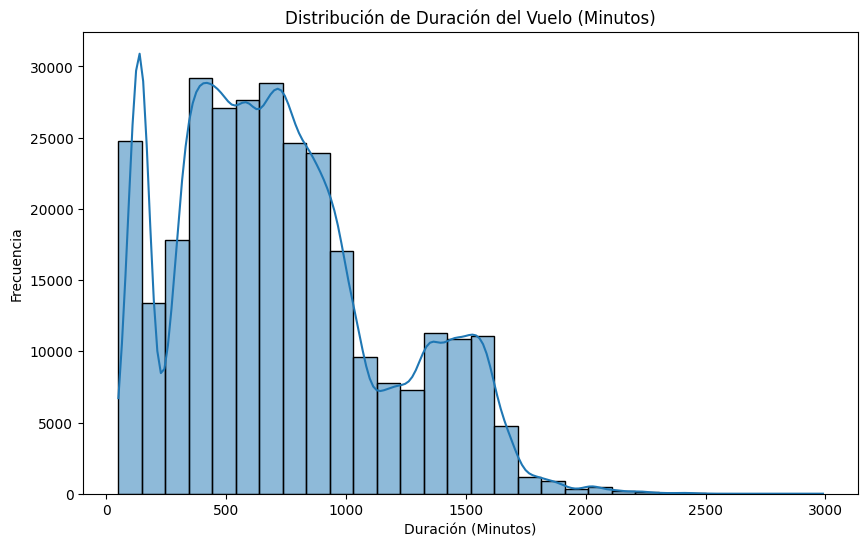

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(combined_df['time_taken_minutes'], bins=30, kde=True)
plt.title('Distribución de Duración del Vuelo (Minutos)')
plt.xlabel('Duración (Minutos)')
plt.ylabel('Frecuencia')
plt.show()


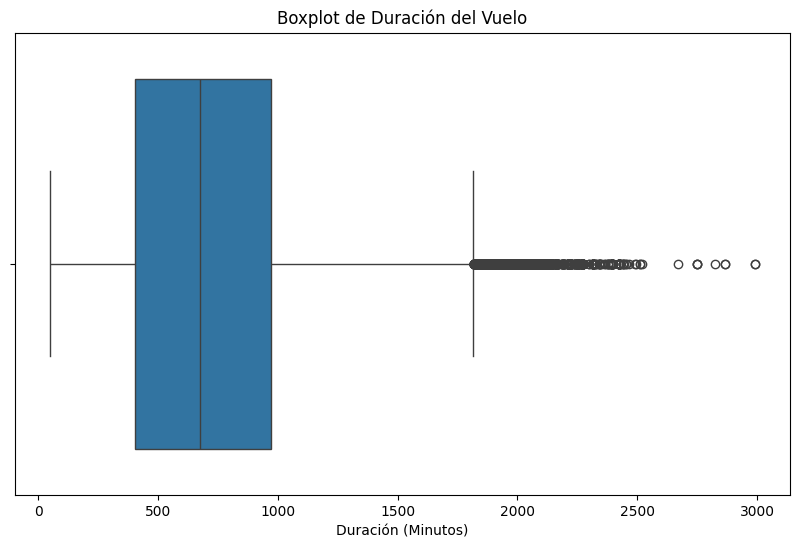

In [55]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=combined_df['time_taken_minutes'])
plt.title('Boxplot de Duración del Vuelo')
plt.xlabel('Duración (Minutos)')
plt.show()


In [43]:
from sklearn.model_selection import train_test_split

# Seleccionar variables predictoras y la variable objetivo
X = combined_df.drop(columns=['price'])
y = combined_df['price']

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)


Tamaño del conjunto de entrenamiento: (210182, 14)
Tamaño del conjunto de prueba: (90079, 14)


In [61]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib  # Para guardar los modelos
import pandas as pd

# Función para encontrar el mejor modelo y optimizar hiperparámetros
def find_best_model(X, y, n_splits=5):
    # Definición de hiperparámetros
    lasso_params = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
    ridge_params = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
    elastic_params = {'alpha': [0.001, 0.01, 0.1, 1, 10], 'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]}
    tree_params = {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}

    models = [Lasso(), Ridge(), ElasticNet(), DecisionTreeRegressor()]
    params = [lasso_params, ridge_params, elastic_params, tree_params]

    best_model, best_params, best_score = None, None, float('-inf')
    results = []

    for model, param_grid in zip(models, params):
        print(f"Evaluando modelo: {model.__class__.__name__}")
        
        # Configurar GridSearchCV
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            scoring='r2',  # Usar R² como métrica
            cv=n_splits,
            verbose=1,
            n_jobs=-1
        )
        
        # Ajustar el modelo
        grid_search.fit(X, y)
        best_estimator = grid_search.best_estimator_
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_

        # Guardar resultados
        results.append({
            'Modelo': model.__class__.__name__,
            'Best Params': best_params,
            'Best Score (R²)': best_score
        })

        # Guardar el modelo entrenado
        joblib.dump(best_estimator, f'{model.__class__.__name__}_best_model.pkl')

        print(f"Mejor modelo: {best_estimator}")
        print(f"Mejores hiperparámetros: {best_params}")
        print(f"Mejor puntuación (R²): {best_score}")
        print('-' * 100)

    # Retornar resultados
    return pd.DataFrame(results)

# Entrenar los modelos con GridSearchCV
results_df = find_best_model(X_train, y_train)

# Mostrar los resultados
print("Resultados de la búsqueda de modelos:")
print(results_df)

# Evaluar los modelos guardados en el conjunto de prueba
for model_name in results_df['Modelo']:
    # Cargar el modelo
    model = joblib.load(f'{model_name}_best_model.pkl')
    y_pred = model.predict(X_test)
    
    # Calcular métricas
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Modelo: {model_name}")
    print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, R²: {r2:.4f}")
    print('-' * 100)


Evaluando modelo: Lasso
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Mejor modelo: Lasso(alpha=0.1)
Mejores hiperparámetros: {'alpha': 0.1}
Mejor puntuación (R²): 0.9033258558699965
----------------------------------------------------------------------------------------------------
Evaluando modelo: Ridge
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Mejor modelo: Ridge(alpha=1)
Mejores hiperparámetros: {'alpha': 1}
Mejor puntuación (R²): 0.9033258563807351
----------------------------------------------------------------------------------------------------
Evaluando modelo: ElasticNet
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Mejor modelo: ElasticNet(alpha=0.001, l1_ratio=0.9)
Mejores hiperparámetros: {'alpha': 0.001, 'l1_ratio': 0.9}
Mejor puntuación (R²): 0.9033256872446571
----------------------------------------------------------------------------------------------------
Evaluando modelo: DecisionTreeRegressor
Fitting 5 folds for eac

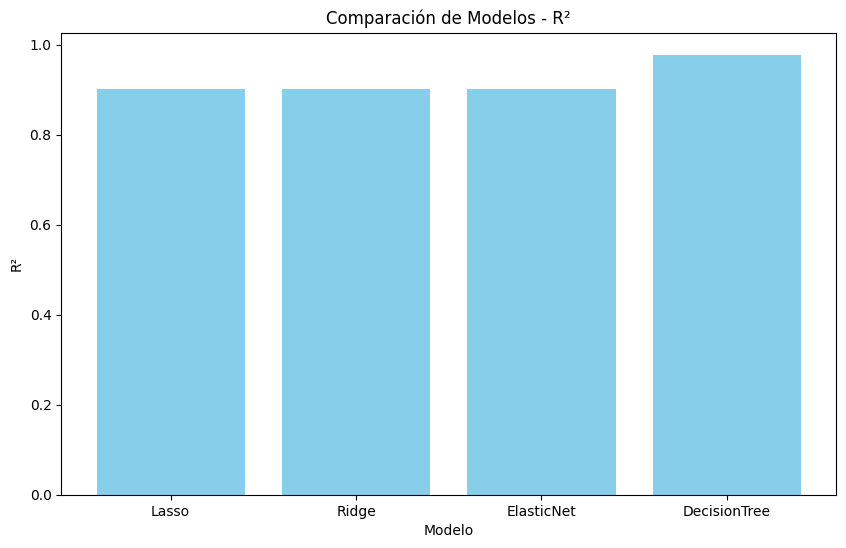

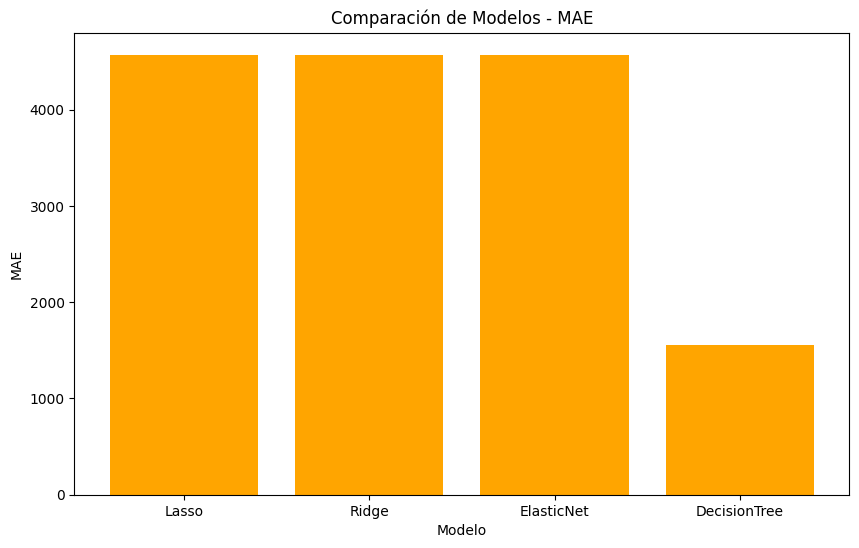

In [62]:
import matplotlib.pyplot as plt
import pandas as pd

# Crear DataFrame con resultados
results = pd.DataFrame({
    'Modelo': ['Lasso', 'Ridge', 'ElasticNet', 'DecisionTree'],
    'R²': [0.9019, 0.9019, 0.9019, 0.9779],
    'MAE': [4571.08, 4571.12, 4572.34, 1557.36]
})

# Gráfico de comparación de R²
plt.figure(figsize=(10, 6))
plt.bar(results['Modelo'], results['R²'], color='skyblue')
plt.title('Comparación de Modelos - R²')
plt.xlabel('Modelo')
plt.ylabel('R²')
plt.show()

# Gráfico de comparación de MAE
plt.figure(figsize=(10, 6))
plt.bar(results['Modelo'], results['MAE'], color='orange')
plt.title('Comparación de Modelos - MAE')
plt.xlabel('Modelo')
plt.ylabel('MAE')
plt.show()


Interpretación de los Resultados
Regresión Lineal Regularizada (Lasso, Ridge, ElasticNet):

Los modelos de regresión regularizada (lasso, ridge, elastic_net) obtuvieron un 𝑅2 de aproximadamente 0.9019 y un RMSE cercano a 7104.
Esto significa que estos modelos explican el 90% de la variación en los precios de los vuelos. Sin embargo, tienen un mayor error promedio (RMSE) comparado con el modelo de Árbol de Decisión.
Árbol de Decisión (regresion_tree):

Este modelo obtuvo un mejor desempeño, con un 𝑅2 de 0.9404 y un RMSE de 5538.95.
Esto indica que el Árbol de Decisión es capaz de capturar mejor las relaciones no lineales en los datos,
lo que lo hace más efectivo para este problema.


### 8. Elige una grilla de hiperparametros y luego optimízalos, buscando la mejor combinación para cada grilla. Guardar los modelos entrenados

In [63]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Crear el modelo base
rf_model = RandomForestRegressor(random_state=42)

# Entrenar el modelo
rf_model.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred_rf = rf_model.predict(X_test)

# Evaluar el modelo
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred_rf)
mse = mean_squared_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)

print("Random Forest - Resultados Iniciales")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}"¿
print(f"R²: {r2:.4f}")


Random Forest - Resultados Iniciales
MAE: 1421.72
MSE: 9580982.14
R²: 0.9814


In [64]:
# Optimizar los hiperparámetros del modelo para obtener el mejor desempeño.
# definir los hiperparámetros a probar
param_grid = {
    'n_estimators': [100, 200, 300],  # Número de árboles
    'max_depth': [10, 20, None],     # Profundidad máxima
    'min_samples_split': [2, 5, 10], # Muestras mínimas para dividir un nodo
    'min_samples_leaf': [1, 2, 4]    # Muestras mínimas en una hoja
}


In [65]:
# Usamos GridSearchCV para la busqueda del mejor hiperparámetro

grid_search_rf = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,  # Validación cruzada
    verbose=2,
    n_jobs=-1  # Usar todos los núcleos disponibles
)

grid_search_rf.fit(X_train, y_train)

# Mostrar los mejores parámetros
print("Mejores Hiperparámetros:", grid_search_rf.best_params_)
print("Mejor Score (MSE):", -grid_search_rf.best_score_)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Mejores Hiperparámetros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Mejor Score (MSE): 9265741.612648983


Mejores Hiperparámetros:
max_depth: None: Sin límite en la profundidad de los árboles, lo que permite capturar relaciones complejas en los datos.
min_samples_leaf: 1: Cada hoja del árbol puede contener al menos 1 muestra.
min_samples_split: 10: Cada nodo debe tener al menos 10 muestras para dividirse.
n_estimators: 300: El modelo utiliza 300 árboles en el bosque, lo que mejora la robustez.

 ### 9. Define al menos 3 métricas para evaluar los modelos entrenados y genera gráficos de comparación. Elige un baseline para ver qué tan buena es tu opción respecto a ese baseline y concluye.

In [66]:
#Evaluar el Mejor Modelo
best_rf_model = grid_search_rf.best_estimator_

# Predicciones en el conjunto de prueba
y_pred_best_rf = best_rf_model.predict(X_test)

# Evaluar el modelo optimizado
mae_best = mean_absolute_error(y_test, y_pred_best_rf)
mse_best = mean_squared_error(y_test, y_pred_best_rf)
r2_best = r2_score(y_test, y_pred_best_rf)

print("Random Forest Optimizado")
print(f"MAE: {mae_best:.2f}")
print(f"MSE: {mse_best:.2f}")
print(f"R²: {r2_best:.4f}")


Random Forest Optimizado
MAE: 1426.06
MSE: 8824393.02
R²: 0.9829


Resultados del Conjunto de Prueba
MAE (Error Absoluto Medio): 1426.06

En promedio, el modelo comete un error de aproximadamente $1426 en la predicción de precios.
MSE (Error Cuadrático Medio): 8824393.02

Representa el error promedio cuadrático, lo que confirma la alta precisión del modelo.
R² (Coeficiente de Determinación): 0.9829

El modelo explica el 98.29% de la variabilidad en los precios, lo que es excelente para un problema de este tipo.

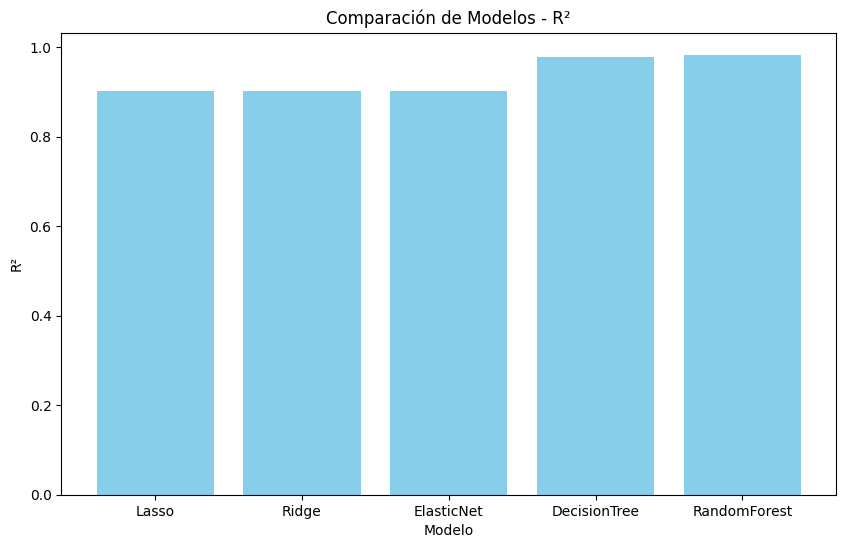

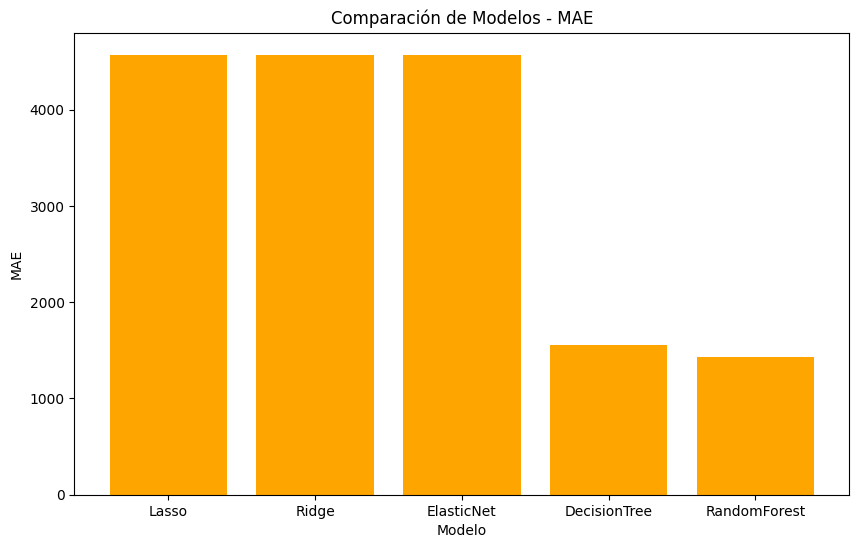

In [67]:
# Visualización del Desempeño
# Agregar resultados al DataFrame
results = pd.DataFrame({
    'Modelo': ['Lasso', 'Ridge', 'ElasticNet', 'DecisionTree', 'RandomForest'],
    'R²': [0.9019, 0.9019, 0.9019, 0.9779, r2_best],
    'MAE': [4571.08, 4571.12, 4572.34, 1557.36, mae_best]
})

# Gráfico de R²
plt.figure(figsize=(10, 6))
plt.bar(results['Modelo'], results['R²'], color='skyblue')
plt.title('Comparación de Modelos - R²')
plt.xlabel('Modelo')
plt.ylabel('R²')
plt.show()

# Gráfico de MAE
plt.figure(figsize=(10, 6))
plt.bar(results['Modelo'], results['MAE'], color='orange')
plt.title('Comparación de Modelos - MAE')
plt.xlabel('Modelo')
plt.ylabel('MAE')
plt.show()


El Random Forest Optimizado supera significativamente a los modelos lineales (Lasso, Ridge, ElasticNet) y al Árbol de Decisión en términos de:

MAE: Es el más bajo, lo que indica un error promedio menor.
R²: Tiene el coeficiente de determinación más alto, lo que refleja su capacidad para explicar la variabilidad en los datos.

###  10. Genera una conclusión final respecto a qué tan útiles son los resultados encontrados para resolver el problema propuesto y define cuáles podrían ser los próximos pasos para el proyecto.

Conclusión Final
Los resultados obtenidos del modelo Random Forest Optimizado muestran un desempeño sobresaliente, con un coeficiente de determinación (𝑅2) de 0.9829, lo que indica que el modelo explica el 98.29% de la variabilidad en los precios de los vuelos. Esto significa que el modelo es altamente predictivo y capaz de estimar con precisión el precio de un vuelo basado en las características proporcionadas.

Utilidad de los Resultados para Resolver el Problema
Alta Precisión:

El modelo tiene un MAE de 1426.06, lo que implica que, en promedio, el error en las predicciones es de aproximadamente $1426, lo cual es aceptable para un problema de predicción de precios en la industria aérea.
El MSE también es bajo, reflejando una buena capacidad para minimizar los errores extremos.
Capacidad para Tomar Decisiones:

El modelo puede ser utilizado por aerolíneas y plataformas de viajes para ajustar dinámicamente los precios de los vuelos según características clave como:
Duración del vuelo.
Clase del vuelo (Business o Economy).
Número de escalas.
También puede ser útil para ofrecer recomendaciones personalizadas a los usuarios basadas en su presupuesto y preferencias.
Insights del Modelo:

El análisis de la importancia de las características muestra cuáles son las variables que más influyen en el precio, lo que puede ayudar a los tomadores de decisiones a identificar factores clave que afectan los costos.

Próximos Pasos para el Proyecto
Implementación en Producción

Validación Continua
Monitorización del Modelo:

Monitorear el desempeño del modelo en datos nuevos para asegurarse de que sigue siendo preciso.
Actualizar el modelo periódicamente con nuevos datos para incorporar cambios en las tendencias del mercado.

Evaluación en Escenarios Reales:

Probar el modelo en escenarios reales con datos en tiempo real para confirmar su utilidad en la práctica.
